# Home Value Prediction

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use regression models to make house price predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

#import my personal modules created for this report
import wrangle as w
#import explore as e
#import model as m

## Acquire

* Data acquired from the Codeup mySQL server on November 16, 2022
* It contained 52,441 rows and 6 columns
* Each observation represents a single-family home
* Each column represents a feature of those homes

In [2]:
#import unclean data from Codeup mySQL server
zillow_unclean = w.acquire_zillow_data()

## Prepare

#### Dropped rows:
* Duplicates   
* Rows where ```bedrooms``` == 0 AND ```bathrooms``` == 0
* Rows where ```square_feet``` >= 10,000  (because these are large and can scew the data)
* Rows where ```home_value``` >= 1,600,000 (because these values are large and can scew the data)
* Rows containing null values in any column

#### Created features
* ```county``` (names based on the fips code):  
    - 6037: LA
    - 6059: Orange 
    - 6111: Ventura 
* ```bath_bed_ratio``` 
    - Column displaying bathrooms/bedrooms
* ```2017_age```
    - Column diplaying age of house in 2017 (2017-year_built)

#### Other prep
* Split data into train, validate, and test (65/20/15)

In [3]:
#clean data
zillow = w.clean_zillow(zillow_unclean)
#split data
train, validate, test = w.split_data(zillow)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
| **bathroooms** | The number of bathrooms in the home. |
| bedrooms | The number of bedrooms in the home. |
|**???**| Definition| *type*|
|**???**| Definition| *type*|
|**???**| Definition| *type*|
|**???**| Definition| *type*|
|**???**| Definition| *type*|
|**Target variable**
|**home_value**| The tax-assessed value of the home. | *float* |

### A look at the data

In [4]:
#show thefirst few rows of the train data
train.head()

,parcelid,bathrooms,bedrooms,home_value,square_feet,year_built,bath_bed_ratio,county,2017_age
43055,13955676,2.5,3,467000.0,1509,2001,0.833333,Orange,16
27580,14184733,3.0,5,411581.0,2822,1993,0.600000,Orange,24
38642,10889898,1.0,2,156917.0,878,1940,0.500000,LA,77
40986,12579090,2.0,4,264953.0,1620,1964,0.500000,LA,53
37881,12919161,2.0,4,402200.0,1128,1955,0.500000,LA,62


## Explore

### 1. Is there a significant relationship between square footage and home value?

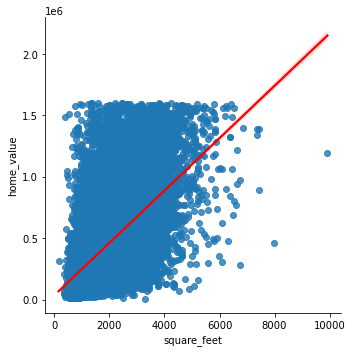

In [5]:
sns.lmplot('square_feet', 'home_value', data=train, line_kws={'color':'red'});

**As suspected, it looks like larger homes have a higher home value**

**Set Hypothesis**

$H_0$ = There is no linear correlation between square feet and home value 

$H_a$ = There is a linear correlation between square feet and home value 

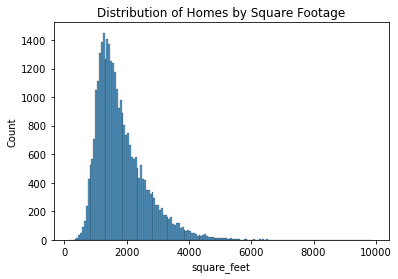

In [6]:
sns.histplot(data = train, x = 'square_feet')
plt.title('Distribution of Homes by Square Footage')
plt.show()

**There is a skewed distribution so I will use the Spearman's R test**

In [7]:
#run spearman test to see if there is any linear correlation
corr, p = stats.spearmanr(train.square_feet, train.home_value)
#Running a significance test to determine whether we can reject the null:

#print results
print(f"Correlation Coefficient: {corr:.2}\np-value: {p:.4}")

Correlation Coefficient: 0.48
p-value: 0.0


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between square feet and home value, but not a very strong one.** 

### 2. Is there a significant relationship between the bath-to-bed ratio and home value? 

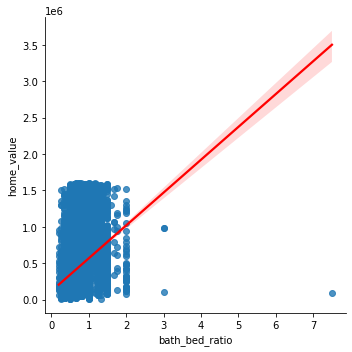

In [8]:
sns.lmplot('bath_bed_ratio', 'home_value', data=train, line_kws={'color':'red'});

**It looks like there is a linear correlation between bath_bed_ratio and home value**

**Set Hypothesis**

$H_0$ = There is no linear correlation between bath_bed_ratio and home value 

$H_a$ = There is a linear correlation between bath_bed_ratio and home value 

In [9]:
#run spearman test to see if there is any linear correlation
corr, p = stats.spearmanr(train.bath_bed_ratio, train.home_value)
#Running a significance test to determine whether we can reject the null:

#print results
print(f"Correlation Coefficient: {corr:.2}\np-value: {p:.4}")

Correlation Coefficient: 0.32
p-value: 0.0


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between bath_bed_ratio and home value.** 

## 3. Does location have a relationship with home value?

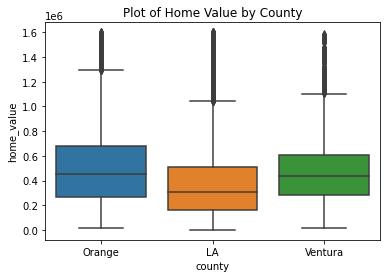

In [10]:
sns.boxplot(data = train, x = 'county', y = 'home_value' )
plt.title('Plot of Home Value by County')
plt.show()

**It looks like there is a difference in home values in each county.**

$H_0$ = Average home values of those in LA county, Orange county and Ventura county are the same.

$H_a$ = Average home values of those in LA county, Orange county and Ventura county are not the same.

In [11]:
#splitting data into a df per county:
la = train[train.county == 'LA'].home_value
orange = train[train.county == 'Orange'].home_value
ventura = train[train.county == 'Ventura'].home_value

#Running a one-way ANOVA (there is a single independent variable - 'county'):
f, p = stats.f_oneway(la, orange, ventura)

print(f"F-score: {f:.8}\np-value: {p:.4}")

F-score: 495.59484
p-value: 9.732e-213


**Since p < alpha we can reject the null hypothesis and say Average home values of those in LA county, Orange county and Ventura county are not the same.**

## 4. Is there a significant relationship between age of the home and home value?

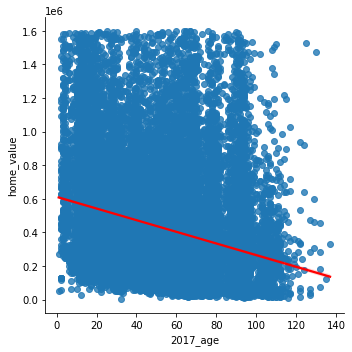

In [12]:
sns.lmplot('2017_age', 'home_value', data=train, line_kws={'color':'red'});

**It looks like there is a linear correlation between bath_bed_ratio and home value**

**Set Hypothesis**

$H_0$ = There is no linear correlation between bath_bed_ratio and home value 

$H_a$ = There is a linear correlation between bath_bed_ratio and home value 

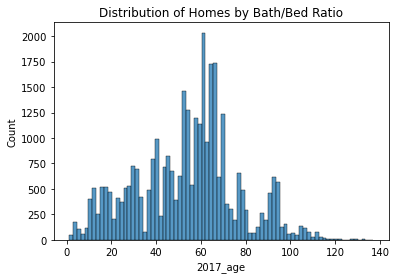

In [13]:
sns.histplot(data = train, x = '2017_age')
plt.title('Distribution of Homes by Bath/Bed Ratio')
plt.show()

In [14]:
#run spearman test to see if there is any linear correlation
corr, p = stats.pearsonr(train['2017_age'], train.home_value)
#Running a significance test to determine whether we can reject the null:

#print results
print(f"Correlation Coefficient: {corr:.8}\np-value: {p:.4}")

Correlation Coefficient: -0.2509302
p-value: 0.0


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between bath_bed_ratio and home value.** 

### Exploration Summary
* 
* 

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|*square_feet*| From our Spearman's R test we saw that there is a 0.48 correlation between ```square_feet``` and ```home_value```|
|*bath_bed_ratio*| From our Spearman's R test we saw that there is a 0.32 correlation between ```bath_bed_ratio``` and ```home_value```|
|*2017_age*| From our Pearson's R test we saw that there is a 0.32 correlation between ```2017_age``` and ```home_value```|
|*county*| From our ANOVA test we see that there is a difference between the home values in each county|

In [15]:
#save drivers into a list
drivers = ['square_feet', 'bath_bed_ratio', '2017_age', 'county']

### Features I'm not moving on with

| Feature | Reason | 
|:--------|:-----------|
|gender| No evidence that gender is a driver of churn
|senior_citizen| No evidence that senior_citizen is a driver of churn
|phone_service| No evidence that phone_service is a driver of churn
|multiple_lines| No evidence that multiple_lines is a driver of churn
|total_charges| There is a strong correlation between total_charges and tenure and between total_charges and monthly_charges. Since I will take tenure and monthly_charges into my model, total_charges is not needed.
|internet_service_type| Remove noise
|payment_type| Remove noise


# Modeling

* I will use accuracy as my evaluation metric
* I had looked at recall, but we cannot determine that false negatives are more costly unless we get more information from the company.
* Didn't churn customers make up 73% of the train data

### Model Testing
* I evaluated on the four different model types and various hyperparameter configurations below
* Models were evaluated on train and validate data to prevent overfitting
* The model that performed the best was then run on the test data

In [16]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, 'home_value', drivers)

In [17]:
X_train.head()

,square_feet,bath_bed_ratio,2017_age,county_Orange,county_Ventura
43055,0.138951,0.086758,0.110294,1,0
27580,0.273398,0.054795,0.169118,1,0
38642,0.074340,0.041096,0.558824,0,0
40986,0.150317,0.041096,0.382353,0,0
37881,0.099939,0.041096,0.448529,0,0


In [18]:
import sklearn.metrics as metric

def make_metric_df(y, y_pred, model_name, metric_df, split = 'train'):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                f'RMSE_{split}': metric.mean_squared_error(
                    y,
                    y_pred) ** .5,
                f'r^2_{split}': metric.explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                f'RMSE_{split}': metric.mean_squared_error(
                    y,
                    y_pred) ** .5,
                f'r^2_{split}': metric.explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [19]:
y_pred_mean = y_train.mean()
y_pred_median = y_train.median()

In [20]:
train_predictions = pd.DataFrame(y_train)
validate_predictions = pd.DataFrame(y_validate)

In [21]:
train_predictions['y_pred_mean'] = y_pred_mean
validate_predictions['y_pred_mean'] = y_pred_mean

train_predictions['y_pred_median'] = y_pred_median
validate_predictions['y_pred_median'] = y_pred_median

In [22]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train,
                           train_predictions.y_pred_mean,
                           'mean_baseline',
                          metric_df)

In [23]:
metric_df = make_metric_df(y_train,
                           train_predictions.y_pred_median,
                           'median_baseline',
                          metric_df)

In [24]:
metric_df

,model,RMSE_train,r^2_train
0,mean_baseline,313878.807820,0.0
1,median_baseline,320546.288486,0.0


### OLS Regressor

In [25]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [26]:
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train)
train_predictions['home_value_pred_lm'] = lm.predict(X_train)
# predict validate
validate_predictions['home_value_pred_lm'] = lm.predict(X_validate)

In [42]:
metric_df = metric_df.append(
            {
                'model': 'OLS', 
                f'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions.home_value_pred_lm) ** .5,
                f'r^2_train': metric.explained_variance_score(
                    y_train,
                    train_predictions.home_value_pred_lm),
                f'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions.home_value_pred_lm) ** .5,
                f'r^2_validate': metric.explained_variance_score(
                    y_validate,
                    validate_predictions.home_value_pred_lm)
            }, ignore_index=True)

### Lasso Lars

In [43]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train)

# predict train
train_predictions['home_value_pred_lars'] = lars.predict(X_train)

# predict validate
validate_predictions['home_value_pred_lars'] = lars.predict(X_validate)

In [44]:
metric_df = metric_df.append(
            {
                'model': 'Lasso Lars', 
                f'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions.home_value_pred_lars) ** .5,
                f'r^2_train': metric.explained_variance_score(
                    y_train,
                    train_predictions.home_value_pred_lars),
                f'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions.home_value_pred_lars) ** .5,
                f'r^2_validate': metric.explained_variance_score(
                    y_validate,
                    validate_predictions.home_value_pred_lars)
            }, ignore_index=True)

### Tweedie

In [45]:
from sklearn.linear_model import TweedieRegressor

In [46]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train)

# predict train
train_predictions['home_value_pred_glm'] = glm.predict(X_train)

# predict validate
validate_predictions['home_value_pred_glm'] = glm.predict(X_validate)



In [47]:
metric_df = metric_df.append(
            {
                'model': 'GLM', 
                f'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions.home_value_pred_glm) ** .5,
                f'r^2_train': metric.explained_variance_score(
                    y_train,
                    train_predictions.home_value_pred_glm),
                f'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions.home_value_pred_glm) ** .5,
                f'r^2_validate': metric.explained_variance_score(
                    y_validate,
                    validate_predictions.home_value_pred_glm)
            }, ignore_index=True)

### Polynomial Features

In [48]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [49]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train)

# predict train
train_predictions['home_value_pred_lm2'] = lm2.predict(X_train_degree2)

# predict validate
validate_predictions['home_value_pred_lm2'] = lm2.predict(X_validate_degree2)


In [50]:
metric_df = metric_df.append(
            {
                'model': 'Quadratic', 
                f'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions.home_value_pred_lm2) ** .5,
                f'r^2_train': metric.explained_variance_score(
                    y_train,
                    train_predictions.home_value_pred_lm2),
                f'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions.home_value_pred_lm2) ** .5,
                f'r^2_validate': metric.explained_variance_score(
                    y_validate,
                    validate_predictions.home_value_pred_lm2)
            }, ignore_index=True)

In [51]:
metric_df

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate
0,mean_baseline,313878.807820,0.000000,NaN,NaN
1,median_baseline,320546.288486,0.000000,NaN,NaN
2,OLS,258979.286048,0.319221,255023.466108,0.335266
3,Lasso Lars,258979.859230,0.319218,255020.856580,0.335280
4,GLM,266071.034814,0.281426,264905.702635,0.282763
5,Quadratic,252612.889098,0.352280,248837.686557,0.367126


### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* KNN had a high train accuracy and lower validate accuracy so it is probably over fit.

### Best model: Random Forest Model 
* I chose the random forest model because the difference in accuracy between the train and validate is less than 1%
* I will now run the random forest model on test data to gauge how it will perform on future data

In [37]:
#get best model results on test data
m.best_model(X_train, y_train, X_test, y_test)

NameError: name 'm' is not defined

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

In [ ]:
#get best model results across all data
m.best_model_comparison(X_train, y_train, X_validate, y_validate, X_test, y_test)

## Conclusion

### Summary
* About 1/4 of our customers churn
* Tenure seems to be a driver of churn
* Monthly_charges seem to be a driver of churn
* Contract_type seems to be a driver of churn
* Tech_support seems to be a driver of churn


### Recommendations
* To reduce churn, I would encourage the company to think about taking the following actions:
    * Seek out young customers and give discounts (lower monthly cost) in order to keep customers longer (increase tenure)
    * Seek out month-to-month contract customers and encourage them to sign a longer contract maybe through discounts
    * Seek out those who don't have tech support and give a free trial of tech support.

### Next Steps
* In the next iteration:
    * Look into how customers with internet add-ons are the same people then can see if they churn more or less.
    * Look into cost of add-ons and see if there are bundles that might reduce monthly charges. That could help us entice more customers to stay.